In [1]:
import pandas as pd
import numpy as np
from typing import Any
from tqdm import tqdm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import odr
from scipy.stats import median_abs_deviation
import pickle
import os
import time
import seaborn as sns
sns.set_theme()

from utils import *

import matplotlib.pyplot as plt

LEVEL = 'member'  # 'member' or 'client'
N = 1
RECOMPUTE = True

column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}


### Intro

Now I start to preprocess the dataframes

In [3]:
PATH_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT"
PATH_NEW_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW"

if os.path.exists(PATH_NEW_DATA_FOLDER) is False:
    os.mkdir(PATH_NEW_DATA_FOLDER)

dfs_paths = [PATH_DATA_FOLDER + '/' + path for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
isins = [path.split('.')[0] for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
print(dfs_paths)
print(isins)

['C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000062072.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000062957.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000066123.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000072170.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000072618.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0000784196.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001078911.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001157020.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001233417.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001250932.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0001347308.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003128367.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003132476.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003153415.csv', 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT/IT0003242622.

One of the original data sets

In [30]:
df = pd.read_csv(dfs_paths[1], sep=';')
df

,ISIN,MIC,EXECUTION_PHASE,TRADING_DAY,TRADETIME,TRADED_QUANTITY,TRADED_PRICE,TRADED_AMOUNT,TRADE_CANCELLATION_INDICATOR,COD_BUY,CLIENT_IDENTIFIC_SHORT_CODE_BUY,PASSIVE_ORDER_INDICATOR_BUY,COD_SELL,CLIENT_IDENTIFIC_SHORT_CODE_SELL,PASSIVE_ORDER_INDICATOR_SELL,TRADING_CAPACITY_BUY,TRADING_CAPACITY_SELL
0,IT0000062957,MTAA,1,14/01/2025,17:02:21.906609750,12,14.705,176.46,0,116286,5169,0.0,117233,5116,1.0,2,3
1,IT0000062957,MTAA,1,10/03/2025,9:24:12.458911658,233,17.330,4037.89,0,116286,0,0.0,117233,7082,1.0,1,3
2,IT0000062957,MTAA,1,14/03/2025,12:24:30.181866366,330,17.070,5633.10,0,116286,0,1.0,117233,13995,0.0,1,3
3,IT0000062957,MTAA,1,14/03/2025,12:24:29.115998181,330,17.060,5629.80,0,116286,0,1.0,117233,13995,0.0,1,3
4,IT0000062957,MTAA,1,10/03/2025,9:23:05.618932782,244,17.300,4221.20,0,116286,0,0.0,117233,7082,1.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156283,IT0000062957,MTAA,2,15/05/2025,9:00:05.988186663,10,21.150,211.50,0,90861,1000154294,0.0,116385,319121,0.0,3,3
1156284,IT0000062957,MTAA,2,19/05/2025,9:00:18.384811180,2165,20.440,44252.60,0,91138,23523,0.0,116385,1191,0.0,2,3
1156285,IT0000062957,MTAA,2,15/05/2025,9:00:05.988186663,12,21.150,253.80,0,91138,23523,0.0,116385,319121,0.0,2,3
1156286,IT0000062957,MTAA,2,31/10/2024,17:35:07.840645522,2020,15.170,30643.40,0,91138,23523,0.0,116385,1191,0.0,2,3


Transform the original datasets

In [8]:
for path in dfs_paths:
    new_path = PATH_NEW_DATA_FOLDER + '/' + os.path.basename(path).split('.')[0] + '.parquet'
    if os.path.exists(new_path):
        print(f"Transformed file for {new_path} already exists. Skipping...")
        continue
    print(f"Processing {path}...")
    df = pd.read_csv(path, sep=';')
    df_mapped = map_trade_codes(df)
    df_transformed = build_trades_view(df_mapped)
    if len(df_transformed[(df_transformed['Total Quantity Buy'] > 0) & (df_transformed['Total Quantity Sell'] > 0)]) > 0:
        print(f"Warning: Both Buy and Sell quantities greater than zero found in {path}. Check data integrity.")
    # display(df_transformed)
    df_transformed.to_parquet(new_path)
    print(f"Saved transformed data to {new_path}.")

NameError: name 'dfs_paths' is not defined

One of te new dataset

In [32]:
df = pd.read_parquet('C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000062072.parquet')
df

,ID Client,ID Member,Trading Venue,Trade Time,Direction,Price First Contract,Price Last Contract,Total Quantity Buy,Total Quantity Sell,Total Amount Buy,Total Amount Sell,Trade Type Aggressive
0,0,45017,MTAA,2024-06-03 09:00:01.918927065,1,23.74,23.74,8332,0,197801.68,0.0,Dealing_on_own_account
1,0,157922,MTAA,2024-06-03 09:00:01.918927065,1,23.74,23.74,25,0,593.50,0.0,Dealing_on_own_account
2,0,354310,MTAA,2024-06-03 09:00:01.918927065,1,23.74,23.74,6660,0,158108.40,0.0,Dealing_on_own_account
3,0,624871,MTAA,2024-06-03 09:00:01.918927065,1,23.74,23.74,840,0,19941.60,0.0,Dealing_on_own_account
4,0,628912,MTAA,2024-06-03 09:00:01.918927065,1,23.74,23.74,2804,0,66566.96,0.0,Dealing_on_own_account
...,...,...,...,...,...,...,...,...,...,...,...,...
639575,1000004314,518084,MTAA,2025-05-30 17:35:02.473583878,1,32.05,32.05,373798,0,11980225.90,0.0,Matched_principal
639576,1088761940,5032,MTAA,2025-05-30 17:35:02.473583878,1,32.05,32.05,130,0,4166.50,0.0,Any_other_capacity
639577,2051,91096,MTAA,2025-05-30 17:35:14.262360783,-1,32.05,32.05,0,22,0.00,705.1,Any_other_capacity
639578,0,619575,MTAA,2025-05-30 17:35:55.454822139,1,32.05,32.05,764,0,24486.20,0.0,Dealing_on_own_account


In [4]:
dfs_path_new = [PATH_NEW_DATA_FOLDER + '/' + path for path in os.listdir(PATH_NEW_DATA_FOLDER) if (path.endswith('.parquet'))]
dfs_path_new

['C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000062072.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000062957.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000066123.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000072170.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000072618.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0000784196.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001078911.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001157020.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001233417.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001250932.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0001347308.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0003128367.parquet',
 'C:/Users/User01/Documents/di_nosse/FTSEMIB_MOT_NEW/IT0003132476.parquet',
 'C:/Users/U

In [34]:
random_path = np.random.choice(dfs_path_new)
df = pd.read_parquet(random_path)
if len(df[(df['Total Quantity Buy'] > 0) & (df['Total Quantity Sell'] > 0)]) > 0:
        print(f"Warning: Both Buy and Sell quantities greater than zero found in {random_path}. Check data integrity.")


### Metaorder computation

In this cell I compute the time series of the metaorders (consecutive trades of the same sign, performed by the same broker for the same client). I use here only trades not made as proprietary trades. The metaorders are evaluated wrt the broker here.

In [5]:
if os.path.exists(f'out_files/metaorders_dict_all_nofilter_{LEVEL}_prop.pkl') and RECOMPUTE==False:
    print(f"Loading metaorders_dict_all_nofilter_{LEVEL}_prop.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_{LEVEL}_prop.pkl')
    print('Done.')
else:
    metaorders_dict_all = {isin:{} for isin in isins}
    for i, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        # Select the corresponding metaorders_dict (now empty)
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        trades_members_numpy = trades_members.to_numpy()

        # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
        column_positions = {'Trade Time': 3, 'ID Member': 1, 'ID Client': 0, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8}
        print('    Evaluating agents activity...')
        # agents_dict, _, _, _ = agents_activity(trades_members_numpy, column_positions, level=LEVEL)
        indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
        print('    Done.')

        # ---------- Reusable dense buffer aligned to all trades ----------
        n_trades = len(trades_members_numpy)
        act_dense = np.zeros(n_trades, dtype=np.int8)

        # ---------- Per-agent metaorders ----------
        for aid in tqdm(indices_by_agent.keys(), desc="    Processing agents"):
            idxs = indices_by_agent[aid]
            signs = act_by_agent[aid]

            if idxs.size == 0:
                continue

            # Fill only the touched locations; rest remains zero
            act_dense[idxs] = signs

            # Find metaorders (constant sign runs in the reduced sequence)
            _, metaorders_original_indexes, n_metaorders = find_metaorders(act_dense, min_child=2)
            if n_metaorders == 0:
                act_dense[idxs] = 0  # reset
                continue

            # Filter: single-child, cross-day, multi-client
            kept = []
            for meta_idx_list in metaorders_original_indexes:
                if len(meta_idx_list) < 2:
                    continue

                # Time constraint: same day
                t_start = pd.Timestamp(trades_members_numpy[meta_idx_list[0], column_positions["Trade Time"]])
                t_end   = pd.Timestamp(trades_members_numpy[meta_idx_list[-1], column_positions["Trade Time"]])
                if t_start.date() != t_end.date():
                    continue

                # Single-client constraint (redundant if level=='client', but kept for safety)
                clients = np.unique(trades_members_numpy[meta_idx_list, column_positions["ID Client"]])
                if len(clients) > 1:
                    continue

                kept.append(meta_idx_list)

            if kept:
                metaorders_dict[aid] = kept

            # Reset only the positions we set (cheap)
            act_dense[idxs] = 0

        # Save back for this ISIN
        metaorders_dict_all[isin] = metaorders_dict

        # Summary
        total_number_metaorders = sum(len(v) for v in metaorders_dict.values())
        print(f"    Total number of metaorders ({isin}): {total_number_metaorders}")

        # Free a bit
        del trades_members, trades_members_numpy, indices_by_agent, act_by_agent, act_dense
        gc.collect()

    #Save on file the metaorders_dict_all without filtering
    print(f"Saving metaorders_dict_all_nofilter_{LEVEL}_prop.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_nofilter_{LEVEL}_prop.pkl')
    print("Done.")


(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 44/44 [00:00<00:00, 54.81it/s]


    Total number of metaorders (IT0000062072): 41878
(2/41) Processing ISIN IT0000062957...
    Loading trades data...
   556022 trades loaded.
    Done.
    246999 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 45/45 [00:00<00:00, 68.79it/s]


    Total number of metaorders (IT0000062957): 41709
(3/41) Processing ISIN IT0000066123...
    Loading trades data...
   1148887 trades loaded.
    Done.
    529579 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:01<00:00, 29.92it/s]


    Total number of metaorders (IT0000066123): 103632
(4/41) Processing ISIN IT0000072170...
    Loading trades data...
   532825 trades loaded.
    Done.
    262486 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 61.21it/s]


    Total number of metaorders (IT0000072170): 42967
(5/41) Processing ISIN IT0000072618...
    Loading trades data...
   2625214 trades loaded.
    Done.
    1353766 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 48/48 [00:03<00:00, 14.76it/s]


    Total number of metaorders (IT0000072618): 240991
(6/41) Processing ISIN IT0000784196...
    Loading trades data...
   346038 trades loaded.
    Done.
    133217 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 36/36 [00:00<00:00, 97.51it/s]


    Total number of metaorders (IT0000784196): 23754
(7/41) Processing ISIN IT0001078911...
    Loading trades data...
   232192 trades loaded.
    Done.
    110993 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 37/37 [00:00<00:00, 123.05it/s]


    Total number of metaorders (IT0001078911): 18605
(8/41) Processing ISIN IT0001157020...
    Loading trades data...
   178584 trades loaded.
    Done.
    81585 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 34/34 [00:00<00:00, 168.62it/s]


    Total number of metaorders (IT0001157020): 14704
(9/41) Processing ISIN IT0001233417...
    Loading trades data...
   351414 trades loaded.
    Done.
    163771 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 66.01it/s]


    Total number of metaorders (IT0001233417): 29592
(10/41) Processing ISIN IT0001250932...
    Loading trades data...
   200108 trades loaded.
    Done.
    95495 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 36/36 [00:00<00:00, 133.42it/s]


    Total number of metaorders (IT0001250932): 16985
(11/41) Processing ISIN IT0001347308...
    Loading trades data...
   294146 trades loaded.
    Done.
    145582 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 36/36 [00:00<00:00, 93.58it/s]


    Total number of metaorders (IT0001347308): 26764
(12/41) Processing ISIN IT0003128367...
    Loading trades data...
   1630077 trades loaded.
    Done.
    747394 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 46/46 [00:01<00:00, 23.40it/s]


    Total number of metaorders (IT0003128367): 117218
(13/41) Processing ISIN IT0003132476...
    Loading trades data...
   1632788 trades loaded.
    Done.
    705414 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:01<00:00, 23.51it/s]


    Total number of metaorders (IT0003132476): 113843
(14/41) Processing ISIN IT0003153415...
    Loading trades data...
   515452 trades loaded.
    Done.
    256511 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 44.44it/s]


    Total number of metaorders (IT0003153415): 43377
(15/41) Processing ISIN IT0003242622...
    Loading trades data...
   456986 trades loaded.
    Done.
    236977 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 68.14it/s]


    Total number of metaorders (IT0003242622): 39074
(16/41) Processing ISIN IT0003261697...
    Loading trades data...
   318763 trades loaded.
    Done.
    137634 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:00<00:00, 132.22it/s]


    Total number of metaorders (IT0003261697): 24479
(17/41) Processing ISIN IT0003492391...
    Loading trades data...
   300282 trades loaded.
    Done.
    154135 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 37/37 [00:00<00:00, 97.78it/s]


    Total number of metaorders (IT0003492391): 28684
(18/41) Processing ISIN IT0003497168...
    Loading trades data...
   958007 trades loaded.
    Done.
    358185 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 42.03it/s]


    Total number of metaorders (IT0003497168): 66204
(19/41) Processing ISIN IT0003796171...
    Loading trades data...
   374651 trades loaded.
    Done.
    152678 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:00<00:00, 95.51it/s]


    Total number of metaorders (IT0003796171): 26185
(20/41) Processing ISIN IT0003828271...
    Loading trades data...
   194343 trades loaded.
    Done.
    99990 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:00<00:00, 125.76it/s]


    Total number of metaorders (IT0003828271): 17759
(21/41) Processing ISIN IT0003856405...
    Loading trades data...
   1301869 trades loaded.
    Done.
    563838 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 45/45 [00:01<00:00, 31.98it/s]


    Total number of metaorders (IT0003856405): 107998
(22/41) Processing ISIN IT0004056880...
    Loading trades data...
   470585 trades loaded.
    Done.
    225050 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 38/38 [00:00<00:00, 67.68it/s]


    Total number of metaorders (IT0004056880): 39735
(23/41) Processing ISIN IT0004176001...
    Loading trades data...
   862631 trades loaded.
    Done.
    440349 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 43/43 [00:00<00:00, 43.28it/s]


    Total number of metaorders (IT0004176001): 77248
(24/41) Processing ISIN IT0004764699...
    Loading trades data...
   304963 trades loaded.
    Done.
    148770 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 34/34 [00:00<00:00, 88.64it/s]


    Total number of metaorders (IT0004764699): 28532
(25/41) Processing ISIN IT0004776628...
    Loading trades data...
   219397 trades loaded.
    Done.
    95984 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 37/37 [00:00<00:00, 162.38it/s]


    Total number of metaorders (IT0004776628): 17761
(26/41) Processing ISIN IT0004810054...
    Loading trades data...
   318970 trades loaded.
    Done.
    140045 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 111.19it/s]


    Total number of metaorders (IT0004810054): 25470
(27/41) Processing ISIN IT0004965148...
    Loading trades data...
   706184 trades loaded.
    Done.
    346786 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:01<00:00, 34.39it/s]


    Total number of metaorders (IT0004965148): 61343
(28/41) Processing ISIN IT0005090300...
    Loading trades data...
   179852 trades loaded.
    Done.
    90257 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 36/36 [00:00<00:00, 154.67it/s]


    Total number of metaorders (IT0005090300): 15899
(29/41) Processing ISIN IT0005211237...
    Loading trades data...
   215627 trades loaded.
    Done.
    109075 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 39/39 [00:00<00:00, 135.69it/s]


    Total number of metaorders (IT0005211237): 20549
(30/41) Processing ISIN IT0005218380...
    Loading trades data...
   1031149 trades loaded.
    Done.
    450599 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 46/46 [00:01<00:00, 37.91it/s]


    Total number of metaorders (IT0005218380): 78922
(31/41) Processing ISIN IT0005239360...
    Loading trades data...
   3038539 trades loaded.
    Done.
    1585460 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 49/49 [00:04<00:00, 11.85it/s]


    Total number of metaorders (IT0005239360): 275529
(32/41) Processing ISIN IT0005278236...
    Loading trades data...
   280941 trades loaded.
    Done.
    138677 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 38/38 [00:00<00:00, 113.39it/s]


    Total number of metaorders (IT0005278236): 25699
(33/41) Processing ISIN IT0005366767...
    Loading trades data...
   598903 trades loaded.
    Done.
    275100 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:00<00:00, 58.70it/s]


    Total number of metaorders (IT0005366767): 48676
(34/41) Processing ISIN IT0005495657...
    Loading trades data...
   973895 trades loaded.
    Done.
    353589 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 42/42 [00:00<00:00, 47.88it/s]


    Total number of metaorders (IT0005495657): 67775
(35/41) Processing ISIN IT0005508921...
    Loading trades data...
   1345552 trades loaded.
    Done.
    587269 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 44/44 [00:01<00:00, 24.72it/s]


    Total number of metaorders (IT0005508921): 101627
(36/41) Processing ISIN LU2598331598...
    Loading trades data...
   686994 trades loaded.
    Done.
    362898 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:00<00:00, 46.20it/s]


    Total number of metaorders (LU2598331598): 63584
(37/41) Processing ISIN NL0000226223...
    Loading trades data...
   1594830 trades loaded.
    Done.
    855559 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 41/41 [00:02<00:00, 19.37it/s]


    Total number of metaorders (NL0000226223): 145286
(38/41) Processing ISIN NL0011585146...
    Loading trades data...
   1200526 trades loaded.
    Done.
    628841 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 47/47 [00:04<00:00, 10.44it/s]


    Total number of metaorders (NL0011585146): 93342
(39/41) Processing ISIN NL00150001Q9...
    Loading trades data...
   2843267 trades loaded.
    Done.
    1448791 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 46/46 [00:04<00:00, 10.84it/s]


    Total number of metaorders (NL00150001Q9): 238947
(40/41) Processing ISIN NL0015000LU4...
    Loading trades data...
   715530 trades loaded.
    Done.
    317819 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 40/40 [00:01<00:00, 26.67it/s]


    Total number of metaorders (NL0015000LU4): 61281
(41/41) Processing ISIN NL0015435975...
    Loading trades data...
   799736 trades loaded.
    Done.
    337828 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 44/44 [00:01<00:00, 24.65it/s]


    Total number of metaorders (NL0015435975): 63123
Saving metaorders_dict_all_nofilter_member_prop.pkl...
Done.


In [6]:
MAX_GAP = pd.Timedelta(hours=1)        # soglia di 1 h
MIN_TRADES = 2

if os.path.exists(f'out_files/metaorders_dict_all_{LEVEL}_prop_.pkl') and RECOMPUTE==False:
    print(f"Loading filtered metaorders_dict_all_{LEVEL}_prop.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_{LEVEL}_prop.pkl')
    print('Done')
else:
    print(f"Loading unfiltered metaorders_dict_all_nofilter_{LEVEL}_prop.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_{LEVEL}_prop.pkl')

    # ---- constants (nanosecond precision for intraday filter) ----
    S_NS  = np.int64(1_000_000_000)
    M_NS  = np.int64(60) * S_NS
    H_NS  = np.int64(60) * M_NS
    DAY_NS = np.int64(24) * H_NS

    START_NS = np.int64(9) * H_NS + np.int64(30) * M_NS           # 09:30:00.000
    END_NS   = np.int64(17) * H_NS + np.int64(30) * M_NS          # 17:30:00.000

    # Convert MAX_GAP to numpy timedelta64[ns] once (fast comparisons later)
    try:
        max_gap_np = MAX_GAP.to_numpy()
    except AttributeError:
        max_gap_np = np.timedelta64(int(MAX_GAP.value), 'ns')

    for i, path in enumerate(dfs_path_new):
        isin = os.path.splitext(os.path.basename(path))[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")

        # alias to avoid repeated dictionary lookups in inner loops
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        # Read only needed columns to reduce IO/memory
        trades_members = pd.read_parquet(path, columns=['Trade Time', 'Trade Type Aggressive'])
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # --- vectorized filter: exclude proprietary + keep [09:30:00, 17:30:00] EXACTLY ---
        tta = trades_members['Trade Type Aggressive'].values
        tm = trades_members['Trade Time']

        # Fast intraday nanoseconds since midnight, preserving timezone semantics:
        # If tz-naive -> use int64 view (ns since epoch) % DAY_NS
        # If tz-aware -> compute from components (hour/min/sec/micro/nano) to avoid UTC shifts
        if tm.dt.tz is None:
            # pandas 2.x: Series.view('i8') works for tz-naive datetime64[ns]
            ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
        else:
            ns_since_midnight = (
                tm.dt.hour.astype(np.int64)   * H_NS +
                tm.dt.minute.astype(np.int64) * M_NS +
                tm.dt.second.astype(np.int64) * S_NS +
                tm.dt.microsecond.astype(np.int64) * np.int64(1_000) +
                tm.dt.nanosecond.astype(np.int64)
            )

        # Inclusive bounds, matching .dt.time.between(..., inclusive='both'):
        in_hours = (ns_since_midnight >= START_NS) & (ns_since_midnight <= END_NS)
        mask = (tta == 'Dealing_on_own_account') & in_hours
        trades_members = trades_members.loc[mask].copy()

        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members.reset_index(drop=True, inplace=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)

        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # Pre-extract the numpy array of times for fast slicing
        times_arr = trades_members['Trade Time'].to_numpy()

        # ---------------------------------------------------------------------
        # loop sui broker/members: split su gap > 1h
        # ---------------------------------------------------------------------
        for member_id, meta_list in metaorders_dict.items():
            new_metaorders = []
            append_nm = new_metaorders.append

            for meta in meta_list:
                if len(meta) < 2:
                    append_nm(meta)
                    continue

                idx_arr = np.asarray(meta, dtype=np.int64)
                ts = times_arr[idx_arr]
                diffs = ts[1:] - ts[:-1]

                split_idx = np.flatnonzero(diffs > max_gap_np)
                if split_idx.size == 0:
                    parts = [idx_arr]
                else:
                    # np.split expects indices after the cut; add 1
                    parts = np.split(idx_arr, split_idx + 1)

                # aggiungi solo i segmenti di lunghezza >= MIN_TRADES
                for part in parts:
                    if part.size >= MIN_TRADES:
                        append_nm(part.tolist())

            metaorders_dict[member_id] = new_metaorders

        # --- stampa il numero totale di meta-ordini per questo btp -------------
        total_meta = sum(len(metas) for metas in metaorders_dict.values())
        print(f"{isin}: {total_meta} metaorders")

    # salva su file
    print(f"Saving filtered metaorders_dict_all_{LEVEL}_prop.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_{LEVEL}_prop.pkl')
    print("Done.")


Loading unfiltered metaorders_dict_all_nofilter_member_prop.pkl...


(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0000062072: 42006 metaorders
(2/41) Processing ISIN IT0000062957...
    Loading trades data...
   556022 trades loaded.
    Done.
    246999 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0000062957: 41821 metaorders
(3/41) Processing ISIN IT0000066123...
    Loading trades data...
   1148887 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    529579 trades after filtering out proprietary trades and outside trading hours.
IT0000066123: 103760 metaorders
(4/41) Processing ISIN IT0000072170...
    Loading trades data...
   532825 trades loaded.
    Done.
    262486 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0000072170: 43070 metaorders
(5/41) Processing ISIN IT0000072618...
    Loading trades data...
   2625214 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    1353766 trades after filtering out proprietary trades and outside trading hours.
IT0000072618: 241166 metaorders
(6/41) Processing ISIN IT0000784196...
    Loading trades data...
   346038 trades loaded.
    Done.
    133217 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0000784196: 23799 metaorders
(7/41) Processing ISIN IT0001078911...
    Loading trades data...
   232192 trades loaded.
    Done.
    110993 trades after filtering out proprietary trades and outside trading hours.
IT0001078911: 18624 metaorders
(8/41) Processing ISIN IT0001157020...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   178584 trades loaded.
    Done.
    81585 trades after filtering out proprietary trades and outside trading hours.
IT0001157020: 14712 metaorders
(9/41) Processing ISIN IT0001233417...
    Loading trades data...
   351414 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    163771 trades after filtering out proprietary trades and outside trading hours.
IT0001233417: 29719 metaorders
(10/41) Processing ISIN IT0001250932...
    Loading trades data...
   200108 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    95495 trades after filtering out proprietary trades and outside trading hours.
IT0001250932: 17070 metaorders
(11/41) Processing ISIN IT0001347308...
    Loading trades data...
   294146 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    145582 trades after filtering out proprietary trades and outside trading hours.
IT0001347308: 26797 metaorders
(12/41) Processing ISIN IT0003128367...
    Loading trades data...
   1630077 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    747394 trades after filtering out proprietary trades and outside trading hours.
IT0003128367: 117334 metaorders
(13/41) Processing ISIN IT0003132476...
    Loading trades data...
   1632788 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    705414 trades after filtering out proprietary trades and outside trading hours.
IT0003132476: 113940 metaorders
(14/41) Processing ISIN IT0003153415...
    Loading trades data...
   515452 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    256511 trades after filtering out proprietary trades and outside trading hours.
IT0003153415: 43504 metaorders
(15/41) Processing ISIN IT0003242622...
    Loading trades data...
   456986 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    236977 trades after filtering out proprietary trades and outside trading hours.
IT0003242622: 39216 metaorders
(16/41) Processing ISIN IT0003261697...
    Loading trades data...
   318763 trades loaded.
    Done.
    137634 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0003261697: 24555 metaorders
(17/41) Processing ISIN IT0003492391...
    Loading trades data...
   300282 trades loaded.
    Done.
    154135 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0003492391: 28744 metaorders
(18/41) Processing ISIN IT0003497168...
    Loading trades data...
   958007 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    358185 trades after filtering out proprietary trades and outside trading hours.
IT0003497168: 66341 metaorders
(19/41) Processing ISIN IT0003796171...
    Loading trades data...
   374651 trades loaded.
    Done.
    152678 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0003796171: 26248 metaorders
(20/41) Processing ISIN IT0003828271...
    Loading trades data...
   194343 trades loaded.
    Done.
    99990 trades after filtering out proprietary trades and outside trading hours.
IT0003828271: 17818 metaorders
(21/41) Processing ISIN IT0003856405...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   1301869 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    563838 trades after filtering out proprietary trades and outside trading hours.
IT0003856405: 108074 metaorders
(22/41) Processing ISIN IT0004056880...
    Loading trades data...
   470585 trades loaded.
    Done.
    225050 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0004056880: 39734 metaorders
(23/41) Processing ISIN IT0004176001...
    Loading trades data...
   862631 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    440349 trades after filtering out proprietary trades and outside trading hours.
IT0004176001: 77344 metaorders
(24/41) Processing ISIN IT0004764699...
    Loading trades data...
   304963 trades loaded.
    Done.
    148770 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0004764699: 28579 metaorders
(25/41) Processing ISIN IT0004776628...
    Loading trades data...
   219397 trades loaded.
    Done.
    95984 trades after filtering out proprietary trades and outside trading hours.
IT0004776628: 17775 metaorders
(26/41) Processing ISIN IT0004810054...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   318970 trades loaded.
    Done.
    140045 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0004810054: 25491 metaorders
(27/41) Processing ISIN IT0004965148...
    Loading trades data...
   706184 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    346786 trades after filtering out proprietary trades and outside trading hours.
IT0004965148: 61406 metaorders
(28/41) Processing ISIN IT0005090300...
    Loading trades data...
   179852 trades loaded.
    Done.
    90257 trades after filtering out proprietary trades and outside trading hours.
IT0005090300: 15984 metaorders
(29/41) Processing ISIN IT0005211237...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   215627 trades loaded.
    Done.
    109075 trades after filtering out proprietary trades and outside trading hours.
IT0005211237: 20601 metaorders
(30/41) Processing ISIN IT0005218380...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   1031149 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    450599 trades after filtering out proprietary trades and outside trading hours.
IT0005218380: 79037 metaorders
(31/41) Processing ISIN IT0005239360...
    Loading trades data...
   3038539 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    1585460 trades after filtering out proprietary trades and outside trading hours.
IT0005239360: 275703 metaorders
(32/41) Processing ISIN IT0005278236...
    Loading trades data...
   280941 trades loaded.
    Done.
    138677 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0005278236: 25782 metaorders
(33/41) Processing ISIN IT0005366767...
    Loading trades data...
   598903 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    275100 trades after filtering out proprietary trades and outside trading hours.
IT0005366767: 48724 metaorders
(34/41) Processing ISIN IT0005495657...
    Loading trades data...
   973895 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    353589 trades after filtering out proprietary trades and outside trading hours.
IT0005495657: 67890 metaorders
(35/41) Processing ISIN IT0005508921...
    Loading trades data...
   1345552 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    587269 trades after filtering out proprietary trades and outside trading hours.
IT0005508921: 101714 metaorders
(36/41) Processing ISIN LU2598331598...
    Loading trades data...
   686994 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    362898 trades after filtering out proprietary trades and outside trading hours.
LU2598331598: 63730 metaorders
(37/41) Processing ISIN NL0000226223...
    Loading trades data...
   1594830 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    855559 trades after filtering out proprietary trades and outside trading hours.
NL0000226223: 145425 metaorders
(38/41) Processing ISIN NL0011585146...
    Loading trades data...
   1200526 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    628841 trades after filtering out proprietary trades and outside trading hours.
NL0011585146: 93522 metaorders
(39/41) Processing ISIN NL00150001Q9...
    Loading trades data...
   2843267 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    1448791 trades after filtering out proprietary trades and outside trading hours.
NL00150001Q9: 239064 metaorders
(40/41) Processing ISIN NL0015000LU4...
    Loading trades data...
   715530 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    317819 trades after filtering out proprietary trades and outside trading hours.
NL0015000LU4: 61269 metaorders
(41/41) Processing ISIN NL0015435975...
    Loading trades data...
   799736 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_13400\724560401.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    337828 trades after filtering out proprietary trades and outside trading hours.
NL0015435975: 63215 metaorders
Saving filtered metaorders_dict_all_member_prop.pkl...
Done.


Check that all the metaorders identified have consistent signs

In [7]:
try:
    with open(f'out_files/metaorders_dict_all_{LEVEL}_prop.pkl', 'rb') as f:
        metaorders_dict_all = pickle.load(f)
except FileNotFoundError:
    print("metaorders_dict_all_nofilter file not found. Please run the metaorders identification script first.")
    exit(1)
for i, path in enumerate(dfs_path_new):
    isin = path.split('/')[-1].split('.')[0]
    trades_members = pd.read_parquet(f'{path}')

    # consider only trades not executed as proprietary trades
    trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
    trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
    # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
    trades_members = trades_members.reset_index(drop=True)
    trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
    trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
    trades_members.reset_index(drop=True, inplace=True)

    for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
        for i in range(len(metaorders_dict_all[isin][id])): # for all member id metaorders
            if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['Direction'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Direction']):
                print('There is a sign problem')
                print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
            if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Client'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Client']):
                print('There is a client problem')
                print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
            if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Member'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Member']):
                print('There is a member problem')
                print(trades_members.iloc[metaorders_dict_all[isin][id][i]])

NL0015435975 Agents: 100%|██████████| 34/34 [01:04<00:00,  1.90s/it]


### Some statistics about metaorders

Number of metaorders per ID Member

(1/41) Processing ISIN IT0000062072...


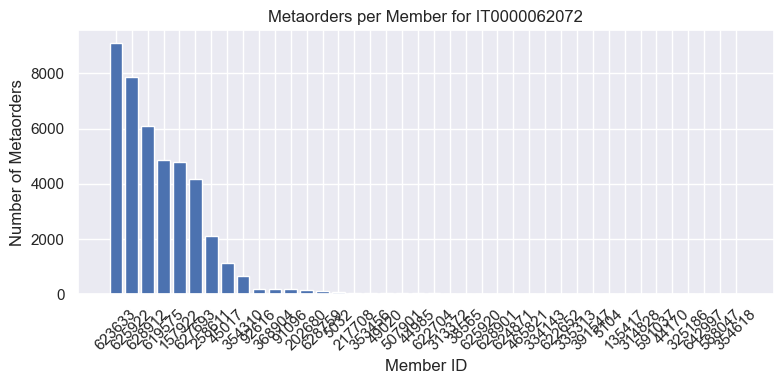

In [38]:
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
    meta_dict = metaorders_dict_all.get(isin, {})
    # Create a list of tuples (member_id, count)
    data = [(member, len(metaorders)) for member, metaorders in meta_dict.items()]
    # Sort by count (ascending, change reverse=True for descending)
    data_sorted = sorted(data, key=lambda x: x[1], reverse=True)
    sorted_member_ids, sorted_counts = zip(*data_sorted) if data_sorted else ([], [])
    
    # Create colors, coloring the bar corresponding to member 10153 in red
    # colors = ["red" if member == 10153 else "skyblue" for member in sorted_member_ids]
    
    plt.figure(figsize=(8,4))
    plt.bar([str(mid) for mid in sorted_member_ids], sorted_counts)#, color=colors)
    plt.title(f'Metaorders per Member for {isin}')
    plt.xlabel('Member ID')
    plt.ylabel('Number of Metaorders')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Longest metaorder per ISIN

(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.
(IT0000062072) Member id with the longest metaorder: 623633
(IT0000062072) Lenght: 67
(IT0000062072) Longest metaorder indexes: [81563, 81565, 81567, 81571, 81574, 81576, 81577, 81581, 81584, 81586, 81587, 81589, 81593, 81594, 81595, 81600, 81602, 81604, 81605, 81607, 81609, 81610, 81611, 81613, 81616, 81623, 81628, 81631, 81638, 81640, 81641, 81643, 81644, 81645, 81647, 81649, 81652, 81654, 81655, 81656, 81659, 81660, 81661, 81662, 81666, 81668, 81669, 81670, 81671, 81673, 81674, 81675, 81677, 81679, 81681, 81682, 81683, 81684, 81686, 81687, 81688, 81689, 81690, 81695, 81697, 81698, 81699]


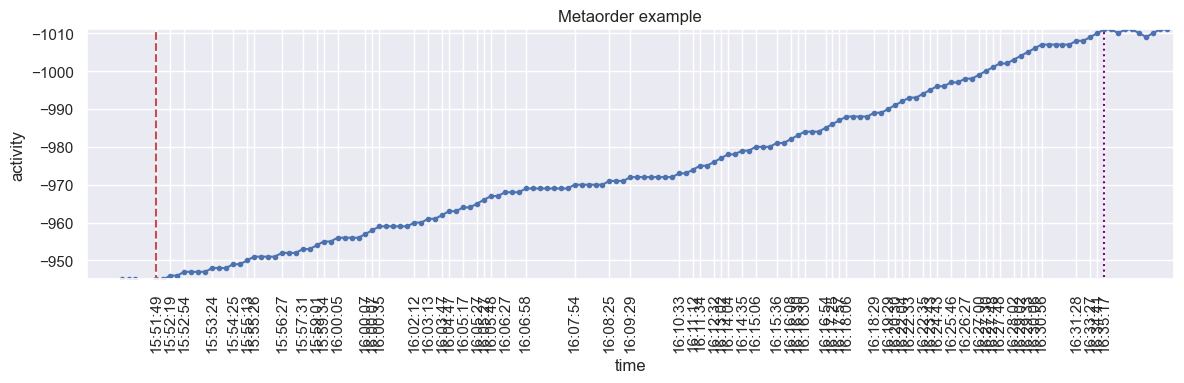

In [ ]:
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
    # Select the corresponding metaorders_dict (now empty)
    metaorders_dict = metaorders_dict_all[isin]

    print('    Loading trades data...')
    trades_members = pd.read_parquet(f'{path}')
    print(f'   {len(trades_members)} trades loaded.')
    print('    Done.')

    # consider only trades not executed as proprietary trades
    trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
    trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
    # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
    trades_members = trades_members.reset_index(drop=True)
    trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
    trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
    trades_members.reset_index(drop=True, inplace=True)
    print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
    trades_members_numpy = trades_members.to_numpy()

    # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
    column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
    print('    Evaluating agents activity...')
    indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
    print('    Done.')
    
    metaorders_dict = metaorders_dict_all[isin]
    # Get the key whose metaorders_dict[key][1] list is the longest
    max_key = max(metaorders_dict, key=lambda k: len(metaorders_dict[k]))
    longest_metaorders_values = metaorders_dict[max_key]

    # Among these, select the longest inner list
    longest_list = max(longest_metaorders_values, key=len)

    print(f"({isin}) Member id with the longest metaorder:", max_key)
    print(f"({isin}) Lenght:", len(longest_list))
    print(f"({isin}) Longest metaorder indexes:", longest_list)
    
    # Build dense activity array for this agent
    n_trades = len(trades_members_numpy)
    act_dense = np.zeros(n_trades, dtype=np.int8)
    idxs = indices_by_agent[max_key]
    signs = act_by_agent[max_key]
    if len(idxs) > 0:
        act_dense[idxs] = signs

    timestamps = trades_members.loc[longest_list, 'Trade Time']
    plt.figure(figsize=(12,4), tight_layout=True)
    plt.plot(np.cumsum(act_dense), marker='o', markersize=3)  # plot the activity
    plt.vlines(longest_list[0], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='r', linestyles='dashed')  # plot the metaorders starts
    plt.vlines(longest_list[-1], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='purple', linestyles='dotted')  # plot the metaorders ends
    # plt.title(f"Longest metaorders in {isin} (agent {max_key})")
    plt.title(f"Metaorder example")
    plt.xlim(longest_list[0] - 10 ,longest_list[-1] + 10)
    plt.ylim(np.cumsum(act_dense)[longest_list[0]], np.cumsum(act_dense)[longest_list[-1]])
    plt.xticks(longest_list, timestamps.dt.strftime('%H:%M:%S'), rotation=90)
    plt.xlabel(f'time')
    plt.ylabel('activity')
    plt.show()
    print()

Distribution of total metaorder duration per ISIN

(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.
Max duration: 7.25 (hours)


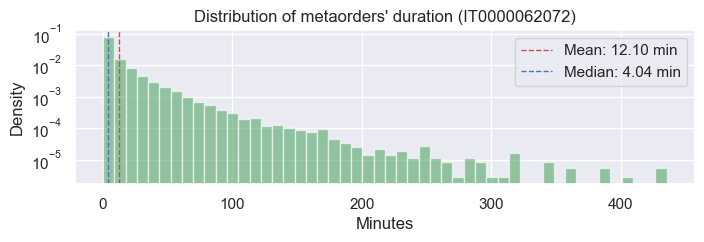

In [ ]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_durations_{LEVEL}_prop.npy') and RECOMPUTE==False:
        print(f"Metaorders durations for {isin} already computed.")
        durations = np.load(f'out_files/{isin}_metaorders_durations_{LEVEL}_prop.npy')
        mean = np.mean(durations)
        median = np.median(durations)
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        # Select the corresponding metaorders_dict (now empty)
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        start_idxs, end_idxs = [], []
        for id in metaorders_dict_all[isin].keys():
            start_idxs = start_idxs + [metaorders_dict_all[isin][id][i][0] for i in range(len(metaorders_dict_all[isin][id]))]
            end_idxs = end_idxs + [metaorders_dict_all[isin][id][i][-1] for i in range(len(metaorders_dict_all[isin][id]))]

        start_times = [trades_members.iloc[str_idx, column_positions['Trade Time']] for str_idx in start_idxs]
        end_times = [trades_members.iloc[end_idx, column_positions['Trade Time']] for end_idx in end_idxs]

        durations = [(end - start).total_seconds() for start, end in zip(start_times, end_times) if start.date() == end.date()]
        durations = np.array(durations)

        np.save(f'out_files/{isin}_metaorders_durations_{LEVEL}_prop.npy', durations)

        mean = np.mean(durations)
        median = np.median(durations)
    
    print(f'Max duration: {np.max(durations)/60/60:.2f} (hours)')

    plt.figure(figsize=(8,2))
    plt.hist(durations/60, bins=50, density=True, alpha=0.6, color='g')
    plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
    plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
    plt.title(f"Distribution of metaorders' duration ({isin})")
    plt.xlabel('Minutes')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Distribution of inter arrival times

(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


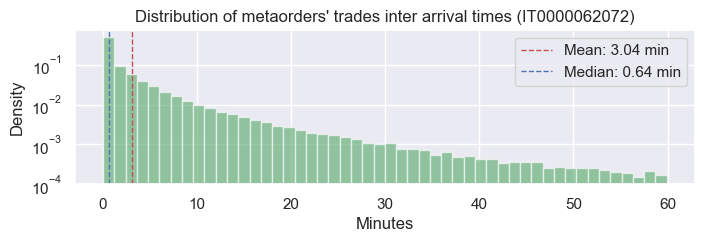

In [ ]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_inter_times_{LEVEL}_prop.npy') and RECOMPUTE==False:
        print(f"Metaorders inter times for {isin} already computed.")
        inter_times = np.load(f'out_files/{isin}_metaorders_inter_times_{LEVEL}_prop.npy')
        mean = np.mean(inter_times)
        median = np.median(inter_times)
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        inter_times = []
        for id in metaorders_dict_all[isin].keys(): # for all members
            for i in range(len(metaorders_dict_all[isin][id])): # for all the metaorders of member id
                inter_times = inter_times + [(trades_members.iloc[metaorders_dict_all[isin][id][i][j+1], column_positions['Trade Time']] - trades_members.iloc[metaorders_dict_all[isin][id][i][j] , column_positions['Trade Time']]).total_seconds() for j in range(len(metaorders_dict_all[isin][id][i]) - 1)]

        inter_times = np.array(inter_times)

        np.save(f'out_files/{isin}_metaorders_inter_times_{LEVEL}_prop.npy', inter_times)

        mean = np.mean(inter_times)
        median = np.median(inter_times)

    plt.figure(figsize=(8,2))
    plt.hist(inter_times/60, bins=50, density=True, alpha=0.6, color='g')
    plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
    plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
    plt.title(f"Distribution of metaorders' trades inter arrival times ({isin})")
    plt.xlabel('Minutes')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Distributions of total volume per metaorder for each ISIN

(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


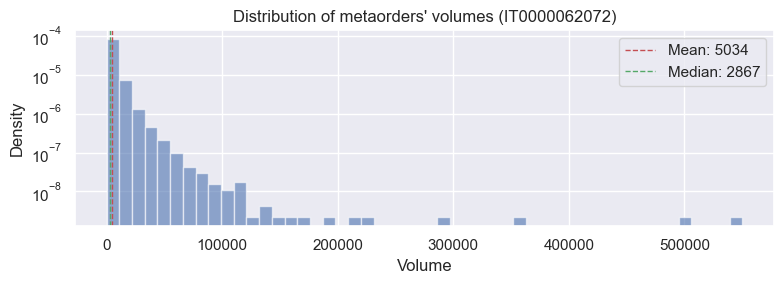

In [ ]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_volume_{LEVEL}_prop.npy') and RECOMPUTE==False:
        print(f"Metaorders inter times for {isin} already computed.")
        metaroder_volumes = np.load(f'out_files/{isin}_metaorders_volume_{LEVEL}_prop.npy')
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        metaorder_volumes = []
        for id in metaorders_dict_all[isin].keys():
            metaorder_volumes = metaorder_volumes + [trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum() for i in range(len(metaorders_dict_all[isin][id]))]
        
        metaorder_volumes = np.array(metaorder_volumes)
        np.save(f'out_files/{isin}_metaorders_volumes_{LEVEL}_prop.npy', metaorder_volumes)

    plt.figure(figsize=(8,3), tight_layout=True)
    plt.hist(metaorder_volumes, bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(metaorder_volumes), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(metaorder_volumes):.0f}')
    plt.axvline(np.median(metaorder_volumes), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(metaorder_volumes):.0f}')
    plt.title(f"Distribution of metaorders' volumes ({isin})")
    plt.xlabel('Volume')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Distribution of daily traded volume

Computing daily traded volumes...
(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


    Processing days: 100%|██████████| 251/251 [00:23<00:00, 10.61it/s]


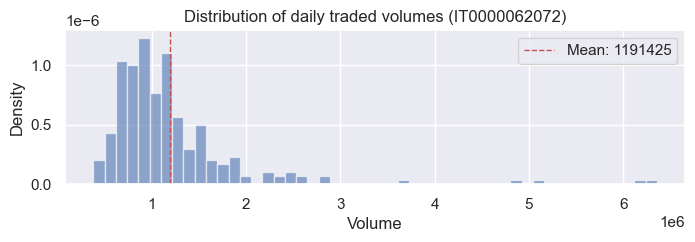

In [ ]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
if os.path.exists(f'out_files/daily_traded_volume_{LEVEL}_prop.npy') and RECOMPUTE==False:
    print("Daily traded volumes already computed.")
    daily_traded_volume = np.load(f'out_files/daily_traded_volume_{LEVEL}_prop.npy', allow_pickle=True)
else:
    print("Computing daily traded volumes...")
    daily_traded_volume = {}
    for i, path in enumerate(dfs_path_new[:N]):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        daily_traded_volume[isin] = {}
        unique_days = sorted(trades_members['Trade Time'].dt.date.unique())

        for day in tqdm(unique_days, desc='    Processing days'):
            day_trades_members = trades_members[trades_members['Trade Time'].dt.date == day].sort_values('Trade Time').reset_index(drop=True)
            daily_vol = day_trades_members[['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum()
            daily_traded_volume[isin][day] = (daily_vol)
    np.save(f'out_files/daily_traded_volume_{LEVEL}_prop.npy', daily_traded_volume)

for isin in isins[:N]:
    plt.figure(figsize=(8,2))
    plt.hist(list(daily_traded_volume[isin].values()), bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(list(daily_traded_volume[isin].values())), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(list(daily_traded_volume[isin].values())):.0f}')
    plt.title(f"Distribution of daily traded volumes ({isin})")
    plt.xlabel('Volume')
    plt.ylabel('Density')
    # plt.yscale('log')
    plt.legend()
    plt.show()

Distribution of Q/V

Computing metaorders volumes and dates...
(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


IT0000062072 Agents: 100%|██████████| 40/40 [59:21<00:00, 89.04s/it]   


Saving metaorder volumes and dates...
Done.


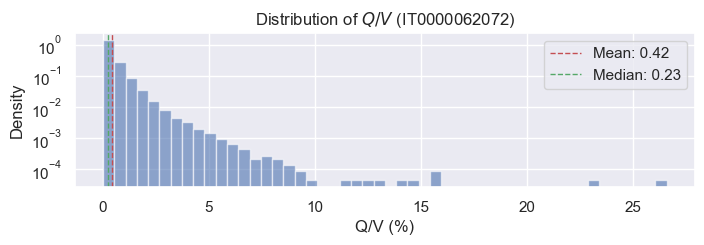

In [ ]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}

if os.path.exists(f'out_files/metaorder_volumes_dates_{LEVEL}_prop.npy') and RECOMPUTE==False:
    print(f"Metaorders inter times for {isin} already computed.")
    metaorder_volumes_dates = np.load(f'out_files/metaorder_volumes_dates_{LEVEL}_prop.npy')
else:
    print(f"Computing metaorders volumes and dates...")
    metaorder_volumes_dates = {isin: None for isin in isins}
    for i, path in enumerate(dfs_path_new[:N]):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        unique_days = sorted(trades_members['Trade Time'].dt.date.unique())
        # daily_volumes = []
        # for day in np.unique(trades_members['Trade Time'].dt.date):
        #     df_day = trades_members[trades_members['Trade Time'].dt.date == day]
        #     day_volume = df_day[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
        #     daily_volumes.append(day_volume)
        # average_daily_vol = np.mean(daily_volumes)

        metaorder_volumes_dates[isin] = {}
        ratios = []
        for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
            l = []
            for i in range(len(metaorders_dict_all[isin][id])):
                vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                date = trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Trade Time'].date()
                # idx = bisect_left(unique_days, date)
                # if idx > 0:
                #     previous_day = unique_days[idx - 1]
                # else:
                #     previous_day = date
                # day = previous_day
                trades_members_filtered = trades_members[trades_members['Trade Time'].dt.date == date]
                daily_volume = trades_members_filtered[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                # ratio = vol/daily_traded_volume[isin][date]
                ratio = vol / daily_volume
                ratios.append(ratio)
                l.append((date, vol, ratio))
            metaorder_volumes_dates[isin][id] = l

print("Saving metaorder volumes and dates...")
np.save(f'out_files/{isin}_metaorders_volumes_dates_{LEVEL}_prop.npy', metaorder_volumes_dates)
print("Done.")
    

for isin in isins[:N]:
    # if btp not in metaorder_volumes_dates:
    #     continue
    ratios = [item[2] for sublist in metaorder_volumes_dates[isin].values() for item in sublist]
    plt.figure(figsize=(8,2))
    plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
    plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
    plt.title(fr"Distribution of $Q/V$ ({isin})")
    plt.xlabel('Q/V (%)')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Distribution of participation rate

(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


IT0000062072 Agents: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


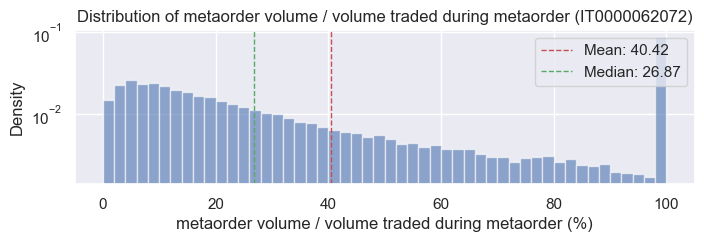

In [ ]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_ratios_{LEVEL}_prop.npy') and RECOMPUTE==False:
        print(f"Metaorders inter times for {isin} already computed.")
        ratios = np.load(f'out_files/{isin}_metaorders_ratios_{LEVEL}_prop.npy')
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        ratios = []
        for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
            l = []
            for i in range(len(metaorders_dict_all[isin][id])):
                met_vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                total_vol_during_met = trades_members.iloc[metaorders_dict_all[isin][id][i][0]:metaorders_dict_all[isin][id][i][-1]+1][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                ratio = met_vol/total_vol_during_met
                ratios.append(ratio)
        
        ratios = np.array(ratios)
        np.save(f'out_files/{isin}_metaorders_ratios_{LEVEL}_prop.npy', ratios)
    
    plt.figure(figsize=(8,2))
    plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
    plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
    plt.title(f"Distribution of metaorder volume / volume traded during metaorder ({isin})")
    plt.xlabel('metaorder volume / volume traded during metaorder (%)')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Signature plots

(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


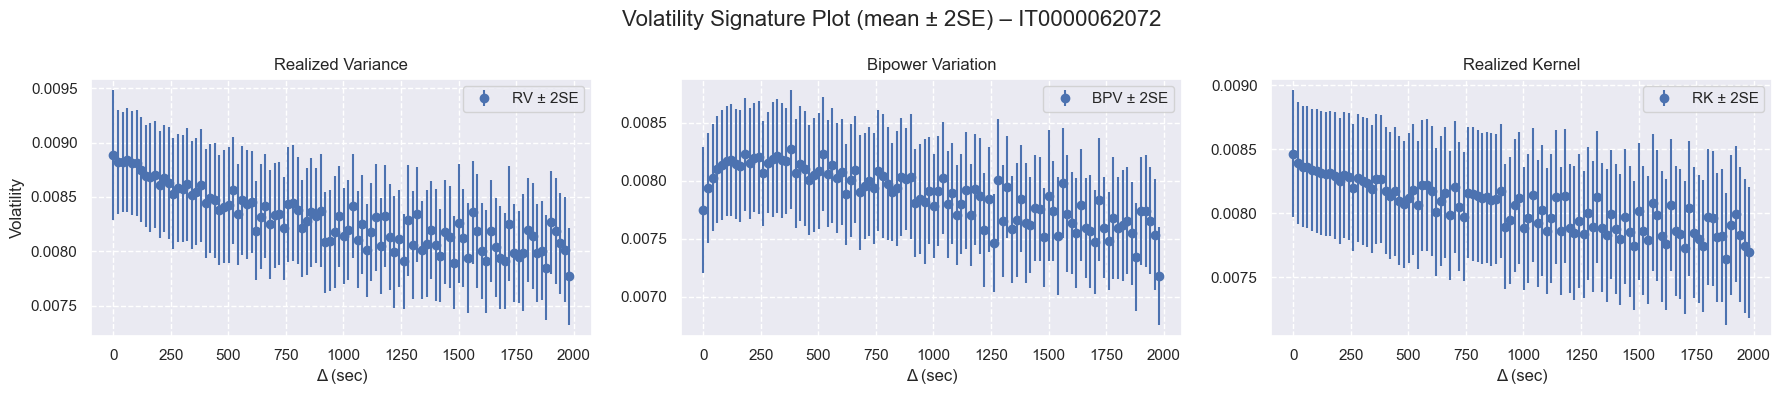

In [46]:
intervals_sec = list(range(1, 2000, 20))
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
    print('    Loading trades data...')
    trades_members = pd.read_parquet(f'{path}')
    print(f'   {len(trades_members)} trades loaded.')
    print('    Done.')

    # consider only trades not executed as proprietary trades
    trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
    trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
    print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

    prices = trades_members[['Trade Time', 'Price Last Contract']]

    mean_rv, se_rv = [], []
    mean_bpv, se_bpv = [], []
    mean_rk, se_rk = [], []

    for sec in intervals_sec:
        delta = f'{sec}s'
        log_returns_dict = preprocess_log_returns(prices.copy(), delta)

        rvs = realized_variance_fast(log_returns_dict)
        bpvs = bipower_variation_fast(log_returns_dict)
        rks = realized_kernel_fast(log_returns_dict)

        rvs = np.array(rvs); bpvs = np.array(bpvs); rks = np.array(rks)

        mean_rv.append(np.nanmean(rvs))
        se_rv.append(np.nanstd(rvs, ddof=1) / np.sqrt(np.sum(~np.isnan(rvs))))

        mean_bpv.append(np.nanmean(bpvs))
        se_bpv.append(np.nanstd(bpvs, ddof=1) / np.sqrt(np.sum(~np.isnan(bpvs))))

        mean_rk.append(np.nanmean(rks))
        se_rk.append(np.nanstd(rks, ddof=1) / np.sqrt(np.sum(~np.isnan(rks))))

    fig, axs = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)

    axs[0].errorbar(intervals_sec, mean_rv, yerr=2*np.array(se_rv), fmt='o', label='RV ± 2SE')
    axs[0].set_title('Realized Variance')
    axs[0].set_xlabel('Δ (sec)')
    axs[0].set_ylabel('Volatility')
    # axs[0].set_xscale('log'); axs[0].set_yscale('log')
    axs[0].grid(True, which='both', ls='--'); axs[0].legend()

    axs[1].errorbar(intervals_sec, mean_bpv, yerr=2*np.array(se_bpv), fmt='o', label='BPV ± 2SE')
    axs[1].set_title('Bipower Variation')
    axs[1].set_xlabel('Δ (sec)')
    # axs[1].set_yscale('log'); axs[1].set_xscale('log')
    axs[1].grid(True, which='both', ls='--'); axs[1].legend()

    axs[2].errorbar(intervals_sec, mean_rk, yerr=2*np.array(se_rk), fmt='o', label='RK ± 2SE')
    axs[2].set_title('Realized Kernel')
    axs[2].set_xlabel('Δ (sec)')
    # axs[2].set_yscale('log'); axs[2].set_xscale('log')
    axs[2].grid(True, which='both', ls='--'); axs[2].legend()

    fig.suptitle(f'Volatility Signature Plot (mean ± 2SE) – {isin}', fontsize=16)
    plt.show()



### SQL Fits

Same day

In [8]:
INFO_PATH = f'out_files/metaorders_info_sameday_{LEVEL}_prop.pkl'  # fixed: consistent path

if os.path.exists(f'out_files/metaorders_info_sameday_{LEVEL}_prop.pkl') and RECOMPUTE==False:
    print("Metaorders info already computed.")
    with open(INFO_PATH, 'rb') as f:
        metaorders_info = pickle.load(f)
else:
    print("Computing metaorders info...")
    try:
        with open(f'out_files/metaorders_dict_all_{LEVEL}_prop.pkl', 'rb') as f:
            metaorders_dict_all = pickle.load(f)
    except FileNotFoundError:
        print("Metaorders dict file not found. Please run the metaorders identification script first.")
        raise SystemExit(1)

    metaorders_info = {isin: {} for isin in isins}

    for i_path, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i_path+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades & within hours
        trades_members = trades_members[trades_members['Trade Type Aggressive'] == 'Dealing_on_own_account'].copy()
        trades_members = trades_members[
            (trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) &
            (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())
        ].copy()

        # Deterministic, stable order: time + original row-id tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # --- extract arrays once for fast NumPy indexing ----------------------
        tt: pd.Series = trades_members['Trade Time']
        day_arr = tt.dt.date.values
        plc = trades_members['Price Last Contract'].to_numpy()
        pfc = trades_members['Price First Contract'].to_numpy()
        direction_arr = trades_members['Direction'].to_numpy()
        member_id_arr = trades_members['ID Member'].to_numpy()
        client_id_arr = trades_members['ID Client'].to_numpy()

        q_buy = trades_members['Total Quantity Buy'].to_numpy(dtype=float)
        q_sell = trades_members['Total Quantity Sell'].to_numpy(dtype=float)
        vol_arr = q_buy + q_sell

        # cumulative sums for O(1) contiguous sums (used for volume_during_metaorder)
        csum_vol = np.cumsum(vol_arr)

        # --- cache daily stats once per day -----------------------------------
        daily_cache = build_daily_cache(trades_members)

        # --- main loops --------------------------------------------------------
        metaorders_info[isin] = {}
        for agent_id in tqdm(metaorders_dict_all[isin].keys(), desc='Processing agents'):
            metaorders_info[isin][agent_id] = {}
            meta_list = metaorders_dict_all[isin][agent_id]  # list of lists of row indices

            for idx_meta, idx_list in enumerate(meta_list):
                # metaorder indices in the *global* trades array
                s = idx_list[0]
                e = idx_list[-1]

                start_ts = tt.iloc[s]
                end_ts   = tt.iloc[e]

                # Metaorder volume Q: sum across those exact indices
                metaorder_volume = float(vol_arr[np.asarray(idx_list, dtype=int)].sum())

                # --- FIX: include the last trade in the contiguous window (end is exclusive)
                # We want the market volume during the metaorder execution from s..e inclusive:
                volume_during_metaorder = sum_contiguous(csum_vol, start=s, end_exclusive=e + 1)

                # Direction epsilon (last trade)
                direction = direction_arr[e]

                # daily stats (cached) - metaorders are same-day by construction
                current_day = day_arr[s]
                daily_vol, daily_volume = daily_cache[current_day]

                # log price movement Delta_p: log(PLC_e) - log(PFC_s)
                delta_p = float(np.log(plc[e]) - np.log(pfc[s]))

                # Q / V
                qv = float(metaorder_volume / daily_volume) if daily_volume != 0 else np.nan

                # Participation rate eta = Q / volume_during_metaorder
                eta = float(metaorder_volume / volume_during_metaorder) if volume_during_metaorder != 0 else np.inf

                n_child = len(idx_list)

                # Store tuple (note: third field was 'ID Member' in your original,
                # if you intended 'client' swap to client_id_arr[e] as below)
                metaorders_info[isin][agent_id][idx_meta] = (
                    isin,
                    agent_id,
                    client_id_arr[e],          # <- use client here if that's what you want in the tuple
                    direction,
                    delta_p,
                    daily_vol,
                    float(metaorder_volume),
                    qv,
                    eta,
                    n_child,
                    [start_ts, end_ts],
                )

    # Save
    with open(INFO_PATH, 'wb') as f:
        pickle.dump(metaorders_info, f)


Computing metaorders info...
(1/41) Processing ISIN IT0000062072...
    Loading trades data...
   639580 trades loaded.
    Done.
    282480 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s]


(2/41) Processing ISIN IT0000062957...
    Loading trades data...
   556022 trades loaded.
    Done.
    246999 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:01<00:00, 22.86it/s]


(3/41) Processing ISIN IT0000066123...
    Loading trades data...
   1148887 trades loaded.
    Done.
    529579 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 39/39 [00:04<00:00,  9.53it/s]


(4/41) Processing ISIN IT0000072170...
    Loading trades data...
   532825 trades loaded.
    Done.
    262486 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 33/33 [00:02<00:00, 11.84it/s]


(5/41) Processing ISIN IT0000072618...
    Loading trades data...
   2625214 trades loaded.
    Done.
    1353766 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 42/42 [00:13<00:00,  3.19it/s]


(6/41) Processing ISIN IT0000784196...
    Loading trades data...
   346038 trades loaded.
    Done.
    133217 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 28/28 [00:01<00:00, 20.91it/s]


(7/41) Processing ISIN IT0001078911...
    Loading trades data...
   232192 trades loaded.
    Done.
    110993 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 28/28 [00:00<00:00, 42.10it/s]


(8/41) Processing ISIN IT0001157020...
    Loading trades data...
   178584 trades loaded.
    Done.
    81585 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 28/28 [00:00<00:00, 53.74it/s]


(9/41) Processing ISIN IT0001233417...
    Loading trades data...
   351414 trades loaded.
    Done.
    163771 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 33/33 [00:01<00:00, 27.82it/s]


(10/41) Processing ISIN IT0001250932...
    Loading trades data...
   200108 trades loaded.
    Done.
    95495 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 29/29 [00:01<00:00, 23.92it/s]


(11/41) Processing ISIN IT0001347308...
    Loading trades data...
   294146 trades loaded.
    Done.
    145582 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 30/30 [00:00<00:00, 30.86it/s]


(12/41) Processing ISIN IT0003128367...
    Loading trades data...
   1630077 trades loaded.
    Done.
    747394 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 41/41 [00:04<00:00,  9.30it/s]


(13/41) Processing ISIN IT0003132476...
    Loading trades data...
   1632788 trades loaded.
    Done.
    705414 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:05<00:00,  6.81it/s]


(14/41) Processing ISIN IT0003153415...
    Loading trades data...
   515452 trades loaded.
    Done.
    256511 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 37/37 [00:01<00:00, 20.45it/s]


(15/41) Processing ISIN IT0003242622...
    Loading trades data...
   456986 trades loaded.
    Done.
    236977 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 32/32 [00:01<00:00, 16.52it/s]


(16/41) Processing ISIN IT0003261697...
    Loading trades data...
   318763 trades loaded.
    Done.
    137634 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:00<00:00, 38.41it/s]


(17/41) Processing ISIN IT0003492391...
    Loading trades data...
   300282 trades loaded.
    Done.
    154135 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 32/32 [00:00<00:00, 32.12it/s]


(18/41) Processing ISIN IT0003497168...
    Loading trades data...
   958007 trades loaded.
    Done.
    358185 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 33/33 [00:02<00:00, 14.49it/s]


(19/41) Processing ISIN IT0003796171...
    Loading trades data...
   374651 trades loaded.
    Done.
    152678 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 33/33 [00:00<00:00, 34.60it/s]


(20/41) Processing ISIN IT0003828271...
    Loading trades data...
   194343 trades loaded.
    Done.
    99990 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 28/28 [00:00<00:00, 44.39it/s]


(21/41) Processing ISIN IT0003856405...
    Loading trades data...
   1301869 trades loaded.
    Done.
    563838 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 37/37 [00:05<00:00,  7.02it/s]


(22/41) Processing ISIN IT0004056880...
    Loading trades data...
   470585 trades loaded.
    Done.
    225050 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 33/33 [00:01<00:00, 22.49it/s]


(23/41) Processing ISIN IT0004176001...
    Loading trades data...
   862631 trades loaded.
    Done.
    440349 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 36/36 [00:03<00:00, 11.26it/s]


(24/41) Processing ISIN IT0004764699...
    Loading trades data...
   304963 trades loaded.
    Done.
    148770 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 29/29 [00:01<00:00, 28.39it/s]


(25/41) Processing ISIN IT0004776628...
    Loading trades data...
   219397 trades loaded.
    Done.
    95984 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 29/29 [00:00<00:00, 31.01it/s]


(26/41) Processing ISIN IT0004810054...
    Loading trades data...
   318970 trades loaded.
    Done.
    140045 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 30/30 [00:00<00:00, 34.92it/s]


(27/41) Processing ISIN IT0004965148...
    Loading trades data...
   706184 trades loaded.
    Done.
    346786 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 40/40 [00:02<00:00, 17.79it/s]


(28/41) Processing ISIN IT0005090300...
    Loading trades data...
   179852 trades loaded.
    Done.
    90257 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 27/27 [00:00<00:00, 49.67it/s]


(29/41) Processing ISIN IT0005211237...
    Loading trades data...
   215627 trades loaded.
    Done.
    109075 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 31/31 [00:00<00:00, 42.96it/s]


(30/41) Processing ISIN IT0005218380...
    Loading trades data...
   1031149 trades loaded.
    Done.
    450599 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


(31/41) Processing ISIN IT0005239360...
    Loading trades data...
   3038539 trades loaded.
    Done.
    1585460 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 45/45 [00:12<00:00,  3.65it/s]


(32/41) Processing ISIN IT0005278236...
    Loading trades data...
   280941 trades loaded.
    Done.
    138677 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 31/31 [00:01<00:00, 29.80it/s]


(33/41) Processing ISIN IT0005366767...
    Loading trades data...
   598903 trades loaded.
    Done.
    275100 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 29/29 [00:01<00:00, 17.39it/s]


(34/41) Processing ISIN IT0005495657...
    Loading trades data...
   973895 trades loaded.
    Done.
    353589 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 36/36 [00:02<00:00, 14.75it/s]


(35/41) Processing ISIN IT0005508921...
    Loading trades data...
   1345552 trades loaded.
    Done.
    587269 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:03<00:00,  9.74it/s]


(36/41) Processing ISIN LU2598331598...
    Loading trades data...
   686994 trades loaded.
    Done.
    362898 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:02<00:00, 14.44it/s]


(37/41) Processing ISIN NL0000226223...
    Loading trades data...
   1594830 trades loaded.
    Done.
    855559 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


(38/41) Processing ISIN NL0011585146...
    Loading trades data...
   1200526 trades loaded.
    Done.
    628841 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]


(39/41) Processing ISIN NL00150001Q9...
    Loading trades data...
   2843267 trades loaded.
    Done.
    1448791 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 41/41 [00:07<00:00,  5.33it/s]


(40/41) Processing ISIN NL0015000LU4...
    Loading trades data...
   715530 trades loaded.
    Done.
    317819 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 31/31 [00:02<00:00, 15.14it/s]


(41/41) Processing ISIN NL0015435975...
    Loading trades data...
   799736 trades loaded.
    Done.
    337828 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 34/34 [00:02<00:00, 14.27it/s]


In [9]:
rows = [
    (isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period)
    for isin_dict in metaorders_info.values()
    for member_dict in isin_dict.values()
    for isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period in member_dict.values()
]

metaorders_info_df_sameday = pd.DataFrame(rows, columns=('ISIN', 'Member', 'Client', 'Direction', 'Price Change', 'Daily Vol', 'Q', 'Q/V', 'Participation Rate', 'N Child', 'Period'))
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0000062072,625922,0,-1,-0.000844,0.070664,1410.0,0.001481,0.239511,2,"[2024-06-03 09:33:39.762178576, 2024-06-03 09:..."
1,IT0000062072,625922,0,1,-0.000422,0.070664,2848.0,0.002990,0.621970,4,"[2024-06-03 09:35:16.526084256, 2024-06-03 09:..."
2,IT0000062072,625922,0,-1,0.000422,0.070664,5355.0,0.005623,0.134978,6,"[2024-06-03 09:47:19.382975180, 2024-06-03 10:..."
3,IT0000062072,625922,0,1,0.000842,0.070664,5696.0,0.005981,0.284061,5,"[2024-06-03 10:21:24.416810377, 2024-06-03 10:..."
4,IT0000062072,625922,0,-1,-0.003793,0.070664,9071.0,0.009525,0.124802,21,"[2024-06-03 10:50:09.321066580, 2024-06-03 11:..."
...,...,...,...,...,...,...,...,...,...,...,...
2740302,NL0015435975,91157,0,-1,0.000346,0.138085,1519.0,0.000375,0.049875,3,"[2025-05-29 11:52:05.426785638, 2025-05-29 12:..."
2740303,NL0015435975,91157,0,-1,-0.012872,0.138085,2829.0,0.000698,0.008454,7,"[2025-05-29 13:49:03.728814140, 2025-05-29 15:..."
2740304,NL0015435975,91157,0,-1,-0.001056,0.138085,1122.0,0.000277,0.012979,2,"[2025-05-29 15:26:36.705075835, 2025-05-29 15:..."
2740305,NL0015435975,91157,0,-1,-0.005281,0.138085,3028.0,0.000747,0.004795,7,"[2025-05-29 16:50:32.519474951, 2025-05-29 17:..."


In [10]:
# Filter metaorders with time horizon >= 60 seconds
metaorders_info_df_sameday = metaorders_info_df_sameday[
    metaorders_info_df_sameday['Period'].apply(
        lambda period: (period[1] - period[0]).total_seconds() >= 60
    )
].reset_index(drop=True)
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0000062072,625922,0,-1,0.000422,0.070664,5355.0,0.005623,0.134978,6,"[2024-06-03 09:47:19.382975180, 2024-06-03 10:..."
1,IT0000062072,625922,0,1,0.000842,0.070664,5696.0,0.005981,0.284061,5,"[2024-06-03 10:21:24.416810377, 2024-06-03 10:..."
2,IT0000062072,625922,0,-1,-0.003793,0.070664,9071.0,0.009525,0.124802,21,"[2024-06-03 10:50:09.321066580, 2024-06-03 11:..."
3,IT0000062072,625922,0,1,-0.000422,0.070664,4228.0,0.004439,0.120425,3,"[2024-06-03 11:24:43.844637337, 2024-06-03 11:..."
4,IT0000062072,625922,0,1,-0.000422,0.070664,920.0,0.000966,0.096265,3,"[2024-06-03 12:23:15.021500291, 2024-06-03 12:..."
...,...,...,...,...,...,...,...,...,...,...,...
1507393,NL0015435975,91157,0,-1,0.000346,0.138085,1519.0,0.000375,0.049875,3,"[2025-05-29 11:52:05.426785638, 2025-05-29 12:..."
1507394,NL0015435975,91157,0,-1,-0.012872,0.138085,2829.0,0.000698,0.008454,7,"[2025-05-29 13:49:03.728814140, 2025-05-29 15:..."
1507395,NL0015435975,91157,0,-1,-0.001056,0.138085,1122.0,0.000277,0.012979,2,"[2025-05-29 15:26:36.705075835, 2025-05-29 15:..."
1507396,NL0015435975,91157,0,-1,-0.005281,0.138085,3028.0,0.000747,0.004795,7,"[2025-05-29 16:50:32.519474951, 2025-05-29 17:..."


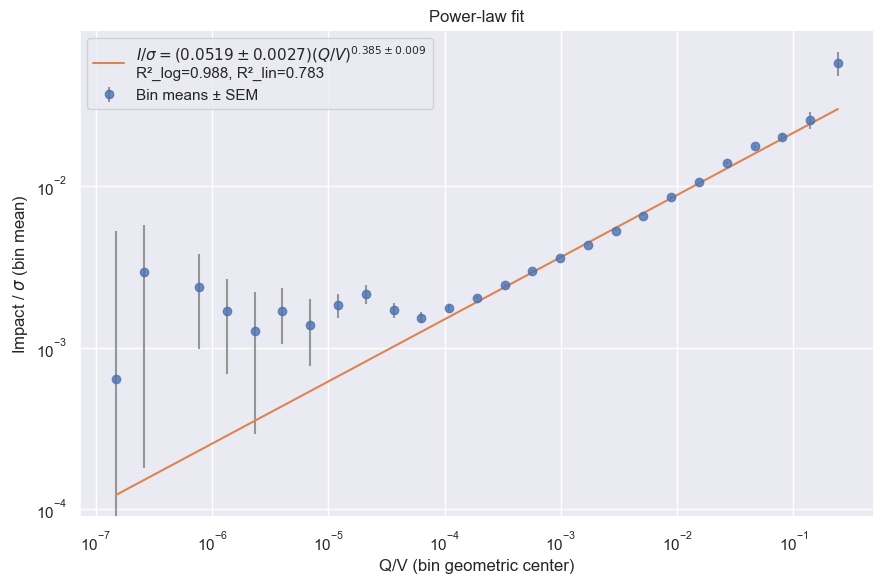

--- Overall (All) ---
Y = 0.0518798 ± 0.00266
γ = 0.384990 ± 0.0087
R²_log = 0.9879 | R²_lin = 0.7828
Bins used: 26 (min_count ≥ 20)


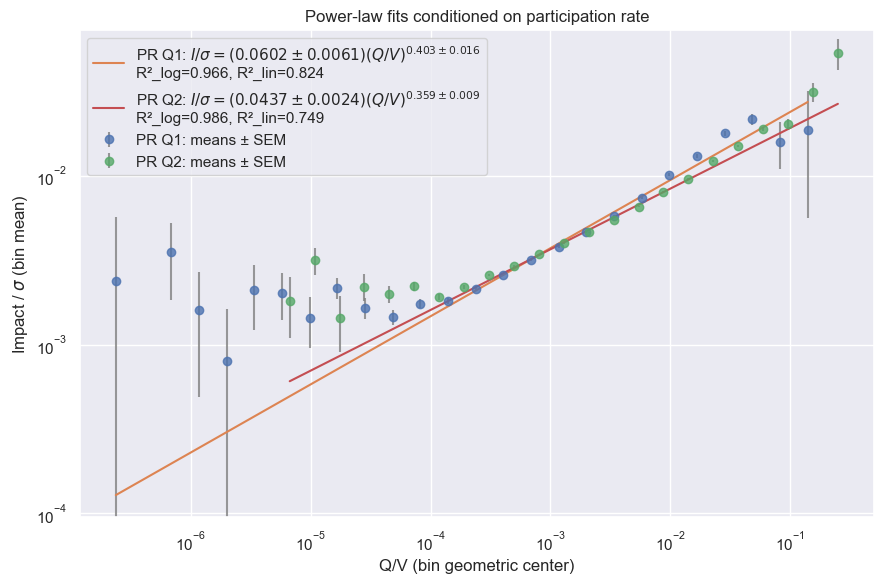

--- Conditioned on Participation Rate ---
[PR Q1]  Y = 0.060235 ± 0.00607 | γ = 0.403129 ± 0.0157 | R²_log = 0.9663 | R²_lin = 0.8235
[PR Q2]  Y = 0.0437427 ± 0.00238 | γ = 0.359064 ± 0.00917 | R²_log = 0.9865 | R²_lin = 0.7489


In [13]:
df = metaorders_info_df_sameday.copy()
df['Impact'] = df['Price Change'] * df['Direction'] / df['Daily Vol']
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Q/V', 'Impact'])
df = df[df['Q/V'] > 0]  # strictly positive for log space

# ----------------------------
# Utilities
# ----------------------------
def power_law(qv, Y, gamma):
    """I/sigma = Y * (Q/V)^gamma"""
    return Y * np.power(qv, gamma)

def fit_power_law_logbins_wls(
    subdf: pd.DataFrame,
    n_logbins: int = 30,
    min_count: int = 100,        # reliability filter: keep only bins with enough obs
    use_median: bool = False     # set True for robustness; paper uses conditional averages (means)
):
    """
    Bin on a fixed log grid in Q/V, compute conditional mean Impact per bin,
    estimate Y, gamma in log–log space via weighted least squares:
        log(I) = log(Y) + gamma * log(Q/V)
    with weights w = 1 / Var[log(mean_imp)] ≈ (mean_imp / SEM)^2.

    Returns:
        binned_df: DataFrame with center_QV, mean_imp, sem_imp, count
        params   : (Y, Y_se, gamma, gamma_se, R2_log, R2_lin)
    """
    sub = subdf[(subdf['Q/V'] > 0) & np.isfinite(subdf['Impact'])].copy()
    if sub.empty:
        raise ValueError("No valid rows (Q/V>0 and finite Impact).")

    x = sub['Q/V'].to_numpy()
    y = sub['Impact'].to_numpy()

    # Fixed log grid on observed support
    x_min = x.min()
    x_max = x.max()
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
        raise ValueError("Invalid Q/V range for log binning.")
    edges = np.logspace(np.log10(x_min), np.log10(x_max), n_logbins + 1)

    # Assign bins
    bin_idx = np.digitize(x, edges) - 1
    mask = (bin_idx >= 0) & (bin_idx < n_logbins)
    x, y, bin_idx = x[mask], y[mask], bin_idx[mask]

    # --- Aggregate in each bin (robust to empty bins) ---
    dfb = pd.DataFrame({'x': x, 'y': y, 'bin': bin_idx})

    agg = (
        dfb.groupby('bin')['y']
           .agg(mean_imp='mean',
                median_imp='median',
                std_imp=lambda s: s.std(ddof=1),
                count='size')
           .sort_index()
    )

    # choose mean/median for the fit
    y_stat = agg['median_imp'] if use_median else agg['mean_imp']
    y_std  = agg['std_imp'].to_numpy()
    n      = agg['count'].to_numpy()
    sem    = y_std / np.sqrt(np.maximum(n, 1))

    # geometric centers for the *present* bins only
    bins_present = agg.index.to_numpy()
    left_edges   = edges[bins_present]
    right_edges  = edges[bins_present + 1]
    x_center     = np.sqrt(left_edges * right_edges)

    binned = pd.DataFrame({
        'center_QV': x_center,
        'mean_imp':  y_stat.to_numpy(),
        'std_imp':   y_std,
        'sem_imp':   sem,
        'count':     n
    }).sort_values('center_QV').reset_index(drop=True)

    # Reliability & positivity filters for log fit
    binned = binned[
        (binned['count'] >= min_count) &
        np.isfinite(binned['mean_imp']) &
        np.isfinite(binned['sem_imp']) &
        (binned['sem_imp'] > 0) &
        (binned['mean_imp'] > 0)
    ]
    if len(binned) < 3:
        raise ValueError(f"Not enough valid bins after filtering (got {len(binned)}). "
                         f"Try lowering min_count or n_logbins.")

    X = np.log(binned['center_QV'].to_numpy())
    Z = np.log(binned['mean_imp'].to_numpy())

    # Delta-method weights: Var[log(mean_imp)] ≈ (SEM/mean)^2  => w = 1/Var
    var_logy = (binned['sem_imp'].to_numpy() / binned['mean_imp'].to_numpy())**2
    w = 1.0 / var_logy
    w = np.where(np.isfinite(w) & (w > 0), w, 0)

    # Weighted least squares for Z = a + gamma * X  (Y = exp(a))
    A = np.vstack([np.ones_like(X), X]).T
    Aw = A * np.sqrt(w)[:, None]
    Zw = Z * np.sqrt(w)
    coef, _, _, _ = np.linalg.lstsq(Aw, Zw, rcond=None)
    a_hat, gamma_hat = coef
    Y_hat = np.exp(a_hat)

    # Covariance of coefficients: cov ≈ sigma^2 * (X' W X)^(-1), sigma^2 from weighted residuals
    res  = Z - (a_hat + gamma_hat * X)
    RSS  = np.sum(w * res**2)
    dof  = max(len(Z) - 2, 1)
    s2   = RSS / dof
    XtWX = A.T @ (w[:, None] * A)
    cov  = s2 * np.linalg.inv(XtWX)
    a_se, gamma_se = np.sqrt(np.diag(cov))
    Y_se = Y_hat * a_se  # delta-method

    # R^2 on log scale (weighted) and on original scale (unweighted, for intuition)
    Zhat = a_hat + gamma_hat * X
    Zbar = np.average(Z, weights=w)
    R2_log = 1.0 - np.sum(w * (Z - Zhat)**2) / np.sum(w * (Z - Zbar)**2)

    yhat   = power_law(binned['center_QV'].to_numpy(), Y_hat, gamma_hat)
    ybar   = np.mean(binned['mean_imp'].to_numpy())
    R2_lin = 1.0 - np.sum((binned['mean_imp'].to_numpy() - yhat)**2) / np.sum((binned['mean_imp'].to_numpy() - ybar)**2)

    return binned, (Y_hat, Y_se, gamma_hat, gamma_se, R2_log, R2_lin)

def plot_fit(ax, binned: pd.DataFrame, params, label_prefix=None):
    """Scatter with SEM bars and fitted curve on log–log axes."""
    Y, Y_err, gamma, gamma_err, R2_log, R2_lin = params

    ax.errorbar(
        binned['center_QV'],
        binned['mean_imp'],
        yerr=binned['sem_imp'],
        fmt='o', alpha=0.8, ecolor='gray',
        label='Bin means ± SEM' if label_prefix is None else f'{label_prefix}: means ± SEM'
    )

    x_min, x_max = binned['center_QV'].min(), binned['center_QV'].max()
    x_grid = np.logspace(np.log10(x_min), np.log10(x_max), 300)
    ax.plot(
        x_grid, power_law(x_grid, Y, gamma),
        label=(rf'{"" if label_prefix is None else label_prefix + ": "}'
               rf'$I/\sigma = ({Y:.3g}\pm{Y_err:.2g})(Q/V)^{{{gamma:.3f}\pm{gamma_err:.3f}}}$'
               f'\nR²_log={R2_log:.3f}, R²_lin={R2_lin:.3f}')
    )

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Q/V (bin geometric center)')
    ax.set_ylabel(r'Impact / $\sigma$ (bin mean)')
    ax.legend(loc='best')

# ----------------------------
# 1) Overall fit (all metaorders)
# ----------------------------
n_logbins = 30
min_count = 20  # raise for larger datasets; lower if data is sparse

binned_all, params_all = fit_power_law_logbins_wls(
    df, n_logbins=n_logbins, min_count=min_count, use_median=False
)

fig, ax = plt.subplots(figsize=(9, 6))
plot_fit(ax, binned_all, params_all)
ax.set_title('Power-law fit')
plt.tight_layout()
plt.savefig(f'images/power_law_fit_overall_{LEVEL}_prop.png', dpi=300)
plt.show()

print('--- Overall (All) ---')
print(f'Y = {params_all[0]:.6g} ± {params_all[1]:.3g}')
print(f'γ = {params_all[2]:.6f} ± {params_all[3]:.3g}')
print(f'R²_log = {params_all[4]:.4f} | R²_lin = {params_all[5]:.4f}')
print(f'Bins used: {len(binned_all)} (min_count ≥ {min_count})')

# ----------------------------
# 2) Conditioning on Participation Rate
# ----------------------------
PR_CANDIDATES = 'Participation Rate'

# Define participation-rate groups via quantiles (change nbins if needed)
pr_nbins = 2
labels = [f'Q{j+1}' for j in range(pr_nbins)]
df = df.copy()
df['PR_bin'] = pd.qcut(df[PR_CANDIDATES], q=pr_nbins, labels=labels, duplicates='drop')

# Fit and plot one curve per PR bin using the *same* WLS procedure
fig, ax = plt.subplots(figsize=(9, 6))
legend_entries = []
fits_by_pr = {}

for label in df['PR_bin'].dropna().unique():
    sub = df[df['PR_bin'] == label]
    try:
        binned_sub, params_sub = fit_power_law_logbins_wls(
            sub, n_logbins=n_logbins, min_count=min_count, use_median=False
        )
    except Exception as e:
        print(f"[{label}] skipped: {e}")
        continue

    plot_fit(ax, binned_sub, params_sub, label_prefix=f'PR {label}')
    fits_by_pr[str(label)] = params_sub

ax.set_title(f'Power-law fits conditioned on participation rate')
plt.tight_layout()
plt.savefig(f'images/power_law_fits_by_participation_rate_{LEVEL}_prop.png', dpi=300)
plt.show()
print('--- Conditioned on Participation Rate ---')
for k, (Y, Y_se, gamma, gamma_se, R2_log, R2_lin) in fits_by_pr.items():
    print(f"[PR {k}]  Y = {Y:.6g} ± {Y_se:.3g} | γ = {gamma:.6f} ± {gamma_se:.3g} | "
          f"R²_log = {R2_log:.4f} | R²_lin = {R2_lin:.4f}")
